In [22]:
class ClusterFile:
    types = {
        'typ' : (str, '%s'),
        'il' : (int, '%d'),
        'ip' : (int, '%d'),
        'ra' : (float, '%.4f'),
        'dec' : (float, '%.4f'),
        'st' : (str, '%s'),
        'amo' : (int, '%d'),
        'in' : (int, '%d'),
        'dia' : (float, '%.4f'),
        'nside' : (int, '%d'),
        'len' : (int, '%d')

    }

    def __init__(self, name):
        import re
        
        #cut .npy.csv.mov.avi.rar
        end = re.findall(r'\.\D+', name)
        if len(end) > 0:
            name = name[:-len(end[-1])]
        
        words = re.split('_', name)
        self.params = {}
        for p in self.types:
            self.params[p] = None
    
        for param in self.params:
            for word in words:
                m = re.match(param, word)
                if not m is None:
                    self.params[param] = self.types[param][0](word[m.end():])
    
    def file(self, end=''):
        res = ''
        for p in self.params:
            if not self.params[p] is None:
                res += p
                res += self.types[p][1] % self.params[p]
                res += '_'
        res = res[:-1]
        return res + end
    
    
    def __getitem__(self, key):
        return self.params[key]
    def __setitem__(self, key, item):
        self.params[key] = item
    


In [23]:
def pix2ra_dec(pix, nside=2**17):
    import healpy as hp
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    l, b = hp.pix2ang(nest=True, ipix=pix, nside=nside, lonlat=True)
    sc = SkyCoord(l=l*u.degree, b=b*u.degree, frame='galactic')
    return sc.icrs.ra.degree, sc.icrs.dec.degree

In [24]:
def pix2pix(pix, nside1=2**10, nside2=2**17):
    import healpy as hp
    vec = hp.pix2vec(nest=True, nside=nside1, ipix=pix)
    return hp.vec2pix(x=vec[0], y=vec[1], z=vec[2], nside=nside2, nest=True)

In [25]:
def dist_ra_dec(coords1, coords2):
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    sc1 = SkyCoord(ra=coords1[0] * u.degree, 
                   dec=coords1[1] * u.degree, frame='icrs')
    sc2 = SkyCoord(ra=coords2[0] * u.degree, 
                   dec=coords2[1] * u.degree, frame='icrs')
    return sc1.separation(sc2).degree

In [26]:
def gen_patches_coords(cat, n, id_list, maxradius, minradius, inpix, dirname, clstdir, nside = 2**17, 
                       try_search=False, nsidet=2**10):
    import numpy as np
    import pandas as pd
    from os.path import join
    from os import walk
    import healpy as hp
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    
    def gen_all_pixels(cat, nsidet=2**10):
        all_pixels = None
        if try_search:
            files = next(walk('/home/rt2122/data/new/all_pixels/'))[-1]
            resfile = None
            for f in files:
                cf = ClusterFile(f)
                if cf['in'] == inpix and minradius - cf['dia'] < 0.1:
                    resfile = f
                    break
            if not resfile is None:
                all_pixels = pd.read_csv(join('~/data/new/all_pixels', resfile), index_col='index')
        if all_pixels is None:
            cat = cat[cat['pix'] == inpix]
            cat.index = np.arange(cat.shape[0])
            all_pixels = np.array([])
            for i in range(cat.shape[0]):
                sc = SkyCoord(ra=cat['ra'][i]*u.degree,
                             dec=cat['dec'][i]*u.degree, frame='icrs')
                vec = hp.ang2vec(sc.galactic.l.degree, 
                                 sc.galactic.b.degree, lonlat=True)
                pixels = hp.query_disc(nside=nsidet, nest=True, vec=vec, 
                                       radius=np.radians(minradius)).flatten()
                all_pixels = np.concatenate([all_pixels, pixels])
            all_pixels = all_pixels.astype(np.int64)
            if try_search:
                all_cf = ClusterFile('')
                all_cf['typ'] = 'allp'
                all_cf['in'] = inpix
                all_cf['dia'] = minradius
                
                np.save(join('/home/rt2122/data/new/all_pixels/', all_cf.file()), all_pixels)
        return all_pixels
    
    
    
    all_pixels = gen_all_pixels(cat, nsidet)
    idxs = []
    for i in range(n):
        idx = np.random.choice(all_pixels)
        idxs.append(idx)
        all_pixels = all_pixels[all_pixels != idx]
    
    cen = pd.DataFrame({'ra' : None,
                       'dec' : None,
                       'pix' : idxs})
    
    cf = ClusterFile('')
    cf['typ'] = 'clust'
    cf['il'] = id_list
    cf['in'] = inpix
    for i in range(n):
        cen['pix'][i] = pix2pix(cen['pix'][i], nside1=nsidet, nside2=nside)
        cen['ra'][i], cen['dec'][i] = pix2ra_dec(nside=nside, pix=cen['pix'][i])
        
        dists = dist_ra_dec((cen['ra'][i], cen['dec'][i]), (cat['ra'], cat['dec']))
        cl_pix = cat[dists < maxradius]
        cf['ra'] = cen['ra'][i]
        cf['dec'] = cen['dec'][i]
        cf['ip'] = i
        
        cl_pix.index = np.arange(cl_pix.shape[0])
        cl_pix.to_csv(join(clstdir, cf.file('.csv')))
        
    
    cen.index.name='index'
    
    cf_cen = ClusterFile('')
    cf_cen['typ'] = 'cen'
    cf_cen['il'] = id_list
    cf_cen['amo'] = n
    cf_cen['in'] = inpix
    cf_cen['dia'] = maxradius
    
    cen.to_csv(join(dirname, cf_cen.file('.csv')))
    
    return cen
        

In [27]:
#1

In [28]:
def download_patches_list(listname, downloaddir, st=0):
    from only_colab import get_patch
    import pandas as pd
    from os.path import join, basename
    from tqdm import tqdm_notebook
    
    cen = pd.read_csv(listname, index_col='index')
    cf_cen = ClusterFile(basename(listname))
    
    cf = ClusterFile('')
    cf['typ'] = 'dat'
    cf['il'] = cf_cen['il']
    cf['st'] = 'ne'
    cf['in'] = cf_cen['in']
    
    for i in tqdm_notebook(range(st, cen.shape[0])):
        cf['ip'] = i
        cf['ra'] = cen['ra'][i]
        cf['dec'] = cen['dec'][i]
        file_name = join(downloaddir, cf.file('.csv'))
        get_patch(cen['ra'][i], cen['dec'][i], cf_cen['dia'] * 60, 
                  job_name='p%d_%d' % (cf_cen['il'], i), file_name=file_name,
                  table_name='p%d_%d' % (cf_cen['il'], i))

In [29]:
def galactic2pix(l, b, nside=2**17):
    import healpy as hp
    return hp.ang2pix(nside=nside, lonlat=True, nest=True, theta=l, phi=b)

In [30]:
def clean_patches(files_list, cdir, files_dir):
    import numpy as np
    from tqdm import tqdm_notebook
    
    
    def remove_duplicates_patch(patch, drop_err=True):
        import pandas as pd
        duplicates = patch.loc[patch.duplicated(subset=["l", "b"], keep='first')]
        coords = set([(l, b) for l, b in zip(duplicates["l"], duplicates["b"])])
        params = [f + par for f in 'grizy' for par in ['KronFlux', 'PSFFlux']]

        for p in params:
            idx = patch[patch[p+'Err'] < -200].index
            patch[p+'Err'][idx] = np.nan
            idx = patch[patch[p] < -200].index
            patch[p][idx]=np.nan

        for l, b in coords:
            index = patch[np.logical_and(patch["l"] == l, patch["b"] == b)].index[0]
            cur_duplicates = duplicates[duplicates["l"] == l][duplicates["b"] == b]
            for p in params:
                err = patch.loc[index, p+'Err']
                min_err = min(cur_duplicates[p+'Err'])
                if err > min_err:
                    val = cur_duplicates[cur_duplicates[p+'Err']==min_err][p].values[0]
                    patch.loc[index, p] = val

        patch.drop_duplicates(subset=["l", "b"], keep='first', inplace=True)
        if drop_err:
            params = [p + 'Err' for p in params]
            patch.drop(params, axis='columns', inplace=True)

        patch.index = np.arange(patch.shape[0])
        return patch

    def calc_pix(patch, nside=2**17):
        import healpy as hp
        
        params = [f + par for f in 'grizy' for par in ['KronFlux', 'PSFFlux']]
        patch['pix'] = np.zeros((patch.shape[0]), dtype=np.int64)
        for i in tqdm_notebook(range(patch.shape[0])):
            theta = patch.iloc[i]["l"]
            phi = patch.iloc[i]["b"]
            patch.loc[i,'pix'] = hp.ang2pix(theta=theta, phi=phi, 
                                             nside=nside, nest=True, lonlat=True)
    
        duplicates = patch.loc[patch.duplicated(subset=['pix'], keep=False)]
        pixels = set(duplicates['pix'])
        
        patch.index = np.arange(patch.shape[0])
        for pix in pixels:
            index = patch[patch['pix'] == pix].index[0]
            cur_duplicates = duplicates[duplicates['pix'] == pix]
            for p in params:
                max_ = max(cur_duplicates[p])
        
        patch.drop_duplicates(subset=['pix'], keep='first', inplace=True)
            

    from os.path import join
    import pandas as pd
    
    for f in files_list:
        cf = ClusterFile(f)
        if cf['typ'] == 'dat' and cf['st'] == 'ne':
            data = pd.read_csv(join(files_dir, f), index_col='index')
            if 'Unnamed: 0' in list(data):
                data.drop(['Unnamed: 0'], inplace=True)
            first_len = data.shape[0]
            remove_duplicates_patch(data)
            calc_pix(data)
            print(cf['ip'], ') Removed:', first_len - data.shape[0])
            cf['st'] = 'cl'
            f_clear = cf.file('.csv')
            print(f_clear)
            data.to_csv(join(cdir,f_clear))



In [31]:
#2

In [32]:
def make_pic(center_pix, nside=2**17, size=2048):
    import healpy as hp
    import numpy as np
    from tqdm import tqdm_notebook

    def get_neighbours(npix, direction=None):
        theta, phi = hp.pix2ang(nside=nside, ipix=npix, nest=True)
        neighbours = hp.get_all_neighbours(nside=nside, theta=theta, phi=phi, nest=True)
        if direction is None:
            return neighbours
        dirs = ['sw', 'w', 'nw', 'n', 'ne', 'e', 'se', 's']
        return neighbours[dirs.index(direction)]

    ''' ~~~~~~~~~~> y 
      |  n __nw__ w
      |    |    |
    x | ne |    | sw
      |    |    |
      \/ e ~~se~~ s

    '''
    half = size // 2
    ans = np.ones((size, size), dtype=np.int64)
    ans *= -1
    ans[half - 1, half - 1] = center_pix
    for i in range(half - 2, -1, -1):
        ans[i, i] = get_neighbours(ans[i + 1, i + 1], 'n')
    for i in range(1, size):
        ans[i, 0] = get_neighbours(ans[i - 1, 0], 'se')
    for i in tqdm_notebook(range(size)):
        for j in range(1, size):
            if ans[i, j] == -1:
                ans[i, j] = get_neighbours(ans[i, j - 1], 'sw')
    return ans


In [33]:
def pix2dict(matr):
    ans = {}
    for i in range(matr.shape[0]):
        for j in range(matr.shape[1]):
            ans[matr[i, j]] = (i, j)
    return ans

In [34]:
def make_matrix_files(cenfile, cendir, mtxdir):
    from os.path import join
    import pandas as pd
    import numpy as np
    
    cen = pd.read_csv(join(cendir, cenfile), index_col='index')
    cf_cen = ClusterFile(cenfile)
    cf = ClusterFile('')
    cf['typ']='mtx'
    cf['len'] = 2048
    
    for i in range(cen.shape[0]):
        cf['ip'] = i
        cf['ra'] = cen['ra'][i]
        cf['dec'] = cen['dec'][i]
        
        mtx = make_pic(cen['pix'][i])
        
        np.save(join(mtxdir, cf.file()), mtx)
        

In [35]:
#3

In [36]:
def visualisation(filename, mtxname, size=2048, p = 80, invert=True):
    import pandas as pd
    import numpy as np
    from skimage.draw import circle
    from os.path import join
    from tqdm import tqdm_notebook
    
    patch = pd.read_csv(filename)
    mtx = pix2dict(np.load(mtxname))
    ans = np.zeros((size, size), dtype=np.uint8)
    print(patch['iKronFlux'].min(), patch['iKronFlux'].max())
    for i in tqdm_notebook(range(patch.shape[0])):
        pix = patch['pix'][i]
        if pix in mtx:
            x, y = mtx[pix]
            flux = patch['iKronFlux'][i]
            if np.isnan(flux) or flux==-999:
                continue
            flux *= p
            ans[circle(x, y, radius=flux, shape=ans.shape)] = 1
    return ans

In [37]:
def make_mask(clstname, mtxname, clust_rad=0.04, size=2048):
    
    import pandas as pd
    import numpy as np
    from os.path import join
    from tqdm import tqdm_notebook
    import healpy as hp
    
    
    def ra_dec2vec(ra, dec):
        from astropy.coordinates import SkyCoord
        import astropy.units as u
        
        sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
        return hp.ang2vec(lonlat=True, theta=sc.galactic.l.degree, phi=sc.galactic.b.degree)
    
    clst = pd.read_csv(clstname)
    mtx = pix2dict(np.load(mtxname))
    
    pixels = []
    for i in range(clst.shape[0]):
        vec = ra_dec2vec(clst['ra'][i], clst['dec'][i])
        pixels.extend(hp.query_disc(nside=2**17, vec=vec, nest=True, radius=np.radians(clust_rad)))
        
    ans = np.zeros((size, size), dtype=np.uint8)
    
    for pix in pixels:
        if pix in mtx:
            ans[mtx[pix]] = 1
    
    return ans

In [38]:
vis = visualisation('/home/rt2122/data/new/try/cl/typdat_il0_ip0_ra90.2878_dec86.1793_stcl_in4.csv', 
                   '/home/rt2122/data/new/try/mtx/typmtx_ip0_ra90.2878_dec86.1793_len2048.npy')

-999.0 0.212365001440048


In [39]:
mask = make_mask('/home/rt2122/data/new/try/clst/typclust_il0_ip0_ra90.2878_dec86.1793_in4.csv', 
                '/home/rt2122/data/new/try/mtx/typmtx_ip0_ra90.2878_dec86.1793_len2048.npy')

In [40]:
import matplotlib.pyplot as plt
import numpy as np

In [41]:
vis *= 255
mask *= 255

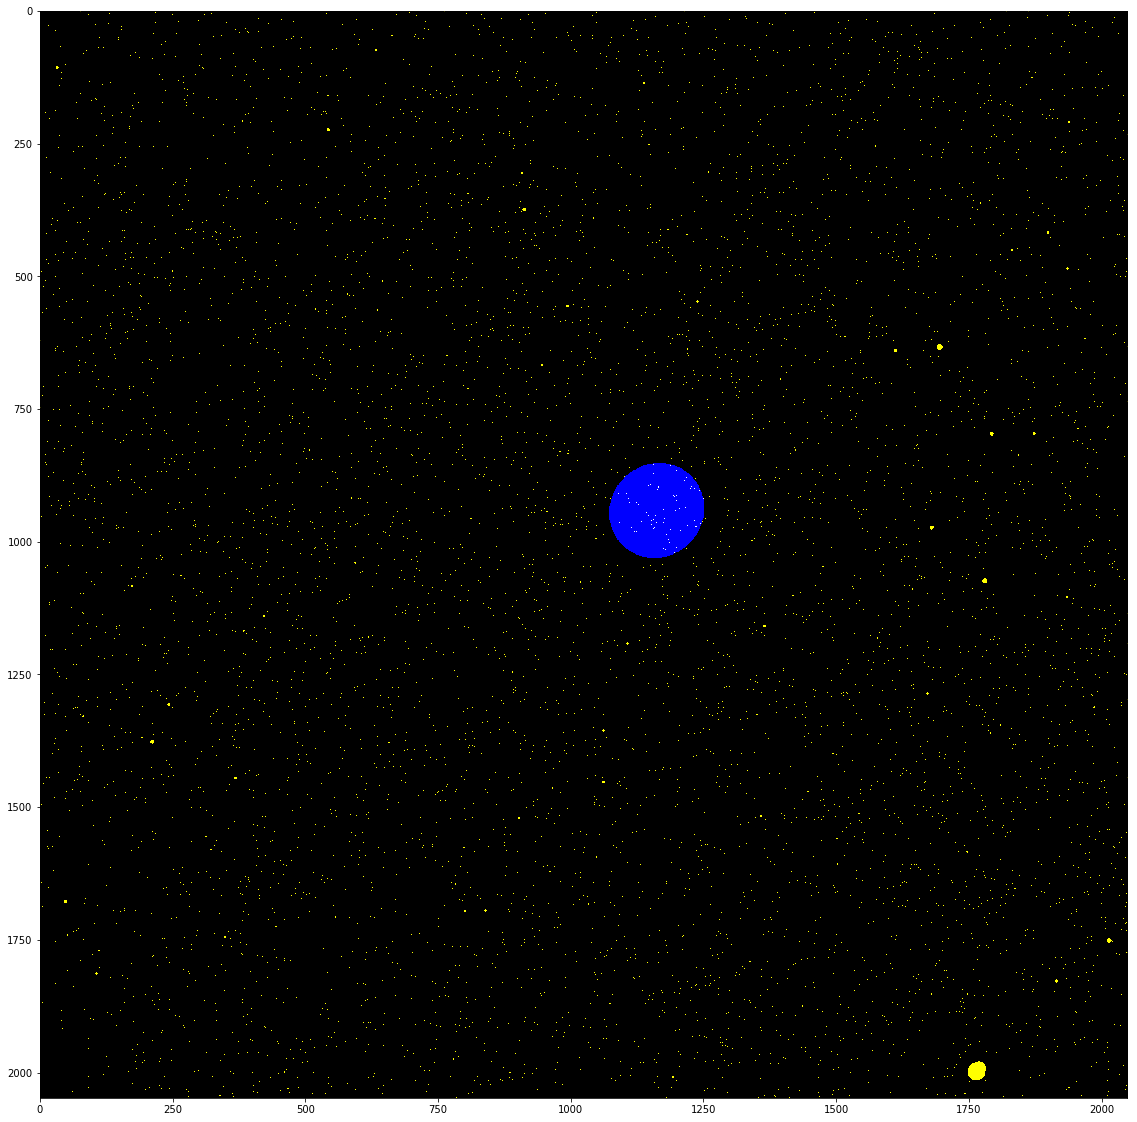

In [42]:
plt.figure(figsize=(20,20))
plt.imshow(np.dstack([vis, vis, mask]))